## UNSEEN via seasonal mean relationships ##

Trying something slightly different. On a seasonal (e.g. ONDJFM) mean timescale, there are likely to be fairly strong relationships between wind speed and wind power generation, temperature and demand, and irradiance and solar power generation. It therefore stands to reason that a combination of these variables, used with a multi linear regression, could project onto the seasonal mean demand net wind (or demand net renewables). Where we have an observed (hopefully linear) relationship between the surface variables and demand net wind (or demand net renewables), we can extrapolate this so that "worse" (i.e. lower wind speeds, colder temperatures, more dull conditions) conditions produced by DePreSys can map onto worse impacts for demand net wind (or demand net renewables). 

Steps for this:

1. Load in the CLEARHEADS dataset and process into demand net wind (+ demand net renewables), along with the surface variables for the different countries (maybe just UK first).
2. Create scatter plots of the relationship between seasonal mean variables (e.g. 10m wind speed/100m wind speed) and the energy system variable (e.g. wind power generation).
3. Create scatter plots for how the individual seasonal mean variables map onto demand net wind/demand net renewables.
4. Create a multi linear regression for mapping the combination of individual surface variables onto demand net wind/demand net renewables.

In [1]:
# Import local modules
import os
import sys
import glob
import time

# Import third-party modules
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# Specific imports
from tqdm import tqdm

In [2]:
# Set up the directory where the clearhedas data are stored
data_dir = '/home/users/benhutch/CLEARHEADS_EU_Power_Data'

# List the clearheads data files
files = os.listdir(data_dir)

files

['EEZ_zones_wp_historical.nc',
 'NUTS_0_CDD_historical_pop_weighted.nc',
 'NUTS_0_HDD_historical_pop_weighted.nc',
 'NUTS_0_sp_historical.nc',
 'NUTS_0_sp_historical_loc_weighted.nc',
 'NUTS_0_speed100m_historical.nc',
 'NUTS_0_speed10m_historical.nc',
 'NUTS_0_speed10m_historical_pop_weighted.nc',
 'NUTS_0_ssrd_historical.nc',
 'NUTS_0_ssrd_historical_pop_weighted.nc',
 'NUTS_0_t2m_detrended_timeseries_historical.nc',
 'NUTS_0_t2m_detrended_timeseries_historical_pop_weighted.nc',
 'NUTS_0_wp_ofs_sim_0_historical_loc_weighted.nc',
 'NUTS_0_wp_ofs_sim_1_historical_loc_weighted.nc',
 'NUTS_0_wp_ons_sim_0_historical_loc_weighted.nc',
 'NUTS_0_wp_ons_sim_1_historical_loc_weighted.nc',
 'NUTS_1_sp_historical.nc',
 'NUTS_1_speed100m_historical.nc',
 'NUTS_1_speed10m_historical.nc',
 'NUTS_1_ssrd_historical.nc',
 'NUTS_1_t2m_detrended_timeseries_historical.nc',
 'NUTS_1_wp_historical.nc',
 'NUTS_2_sp_historical.nc',
 'NUTS_2_speed100m_historical.nc',
 'NUTS_2_speed10m_historical.nc',
 'NUTS_2

In [3]:
# Create a list of the files to extract
files_to_extract = [
    "NUTS_0_sp_historical.nc",
    "NUTS_0_speed100m_historical.nc",
    "NUTS_0_speed10m_historical.nc",
    "NUTS_0_ssrd_historical.nc",
    "NUTS_0_wp_ofs_sim_0_historical_loc_weighted.nc",
    "NUTS_0_wp_ons_sim_0_historical_loc_weighted.nc",
]

# Create a list with the names
names = [
    "solar_power",
    "100m_wind_speed",
    "10m_wind_speed",
    "solar_irradiance",
    "ofs_cfs",
    "ons_cfs",
]

# set up the country code to extract for
country_code = "FR" # France

In [4]:
# Set up an empty dataframe to store the data
df_full = pd.DataFrame()

# Loop over the files to extract
for file, name in tqdm(zip(files_to_extract, names)):
    # Load the data
    file_path = os.path.join(data_dir, file)

    # assert that the file exists
    assert os.path.exists(file_path), f"File {file_path} does not exist"

    # Load the data
    ds = xr.open_dataset(file_path)

    # # print ds.variables
    # print(ds.variables)

    # assert that NUTS_keys is in the variables
    assert "NUTS_keys" in ds.variables, f"Variable NUTS_keys not found in {file_path}"

    # extract the nuts keys
    nuts_keys = ds["NUTS_keys"].values

    # turn the data into a dataframe
    df = ds.to_dataframe()

    # Pivot the dataframe
    df_pivot = df.reset_index().pivot(
        index="time_in_hours_from_first_jan_1950",
        columns="NUTS",
        values="timeseries_data",
    )

    # set the columns as the nuts keys
    df_pivot.columns = nuts_keys

    # Convert 'time_in_hours_from_first_jan_1950' column to datetime
    df_pivot.index = pd.to_datetime(df_pivot.index, unit="h", origin="1950-01-01")

    # constrain to the "UK" column
    df_pivot = df_pivot[country_code]

    # if this is the first iteration, set the index
    if df_full.empty:
        df_full = df_pivot.to_frame(name=name)
    else:
        df_full[name] = df_pivot

    # # print the head of the dataframe
    # print(df_full.head())

    # sys.exit()

0it [00:00, ?it/s]

6it [00:31,  5.27s/it]


In [5]:
df_full.head()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs
time_in_hours_from_first_jan_1950,,,,,,
1950-01-01 00:00:00,0.0,6.474597,3.260597,0.0,0.594916,0.357931
1950-01-01 01:00:00,0.0,6.432087,3.221744,0.0,0.544015,0.336420
1950-01-01 02:00:00,0.0,6.516265,3.249861,0.0,0.526996,0.324147
1950-01-01 03:00:00,0.0,6.533144,3.223810,0.0,0.594916,0.322193
1950-01-01 04:00:00,0.0,6.418404,3.137180,0.0,0.658595,0.317397


In [6]:
# import the temperature data with different levels of detrending
file_path = os.path.join(data_dir, "NUTS_0_t2m_detrended_timeseries_historical.nc")

# assert that the file exists
assert os.path.exists(file_path), f"File {file_path} does not exist"

# Load the data
ds = xr.open_dataset(file_path)

# # print ds.variables
# print(ds.variables)

# assert that NUTS_keys is in the variables
assert "NUTS_keys" in ds.variables, f"Variable NUTS_keys not found in {file_path}"

# extract the nuts keys
nuts_keys = ds["NUTS_keys"].values

# trend levle = [1950., 1980., 2010., 2020.,    0.]

# Select the level of detrending
# print the trend_levels variable
print(ds["trend_levels"])

trend_level = 0

# select 0 detrend
# extract the trend levels
trend_levels = ds.trend_levels.values

# Find the index of the trend level
idx = np.where(trend_levels == trend_level)[0][0]

# print the index
print(idx)

# Extract the data
ds = ds.isel(trend=idx)

# turn the data into a dataframe
df = ds.to_dataframe()

# Pivot the dataframe
df_pivot = df.reset_index().pivot(
    index="time_in_hours_from_first_jan_1950",
    columns="NUTS",
    values="detrended_data",
)

# set the columns as the nuts keys
df_pivot.columns = nuts_keys

# Convert 'time_in_hours_from_first_jan_1950' column to datetime
df_pivot.index = pd.to_datetime(df_pivot.index, unit="h", origin="1950-01-01")

# constrain to the "UK" column
df_pivot = df_pivot[country_code]

# if this is the first iteration, set the index
if df_full.empty:
    df_full = df_pivot.to_frame(name="t2m_no_detrend")
else:
    df_full["t2m_no_detrend"] = df_pivot

<xarray.DataArray 'trend_levels' (trend: 5)>
[5 values with dtype=float32]
Dimensions without coordinates: trend
4


In [7]:
# import the temperature data with different levels of detrending
file_path = os.path.join(data_dir, "NUTS_0_t2m_detrended_timeseries_historical.nc")

# assert that the file exists
assert os.path.exists(file_path), f"File {file_path} does not exist"

# Load the data
ds = xr.open_dataset(file_path)

# # print ds.variables
# print(ds.variables)

# assert that NUTS_keys is in the variables
assert "NUTS_keys" in ds.variables, f"Variable NUTS_keys not found in {file_path}"

# extract the nuts keys
nuts_keys = ds["NUTS_keys"].values

# trend levle = [1950., 1980., 2010., 2020.,    0.]

# Select the level of detrending
# print the trend_levels variable
print(ds["trend_levels"])

trend_level = 2020

# select 0 detrend
# extract the trend levels
trend_levels = ds.trend_levels.values

# Find the index of the trend level
idx = np.where(trend_levels == trend_level)[0][0]

# print the index
print(idx)

# Extract the data
ds = ds.isel(trend=idx)

# turn the data into a dataframe
df = ds.to_dataframe()

# Pivot the dataframe
df_pivot = df.reset_index().pivot(
    index="time_in_hours_from_first_jan_1950",
    columns="NUTS",
    values="detrended_data",
)

# set the columns as the nuts keys
df_pivot.columns = nuts_keys

# Convert 'time_in_hours_from_first_jan_1950' column to datetime
df_pivot.index = pd.to_datetime(df_pivot.index, unit="h", origin="1950-01-01")

# constrain to the "UK" column
df_pivot = df_pivot[country_code]

# if this is the first iteration, set the index
if df_full.empty:
    df_full = df_pivot.to_frame(name="t2m_2020_detrend")
else:
    df_full["t2m_2020_detrend"] = df_pivot

<xarray.DataArray 'trend_levels' (trend: 5)>
[5 values with dtype=float32]
Dimensions without coordinates: trend
3


In [8]:
df_full.head()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend
time_in_hours_from_first_jan_1950,,,,,,,,
1950-01-01 00:00:00,0.0,6.474597,3.260597,0.0,0.594916,0.357931,1.799430,3.594835
1950-01-01 01:00:00,0.0,6.432087,3.221744,0.0,0.544015,0.336420,1.671031,3.466432
1950-01-01 02:00:00,0.0,6.516265,3.249861,0.0,0.526996,0.324147,1.399019,3.194417
1950-01-01 03:00:00,0.0,6.533144,3.223810,0.0,0.594916,0.322193,0.631590,2.426986
1950-01-01 04:00:00,0.0,6.418404,3.137180,0.0,0.658595,0.317397,0.546507,2.341899


## Demand for other countries S2S4E ##

In [9]:
s2s4e_dir = "/home/users/benhutch/ERA5_energy_update/"

s2s4e_demand_fname = "ERA5_weather_dependent_demand_1979_2018.csv"

# Load the demand data
df_demand = pd.read_csv(os.path.join(s2s4e_dir, s2s4e_demand_fname))

In [10]:
df_demand.head()

,Unnamed: 0,Austria_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,Belgium_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,Bulgaria_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,Croatia_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,Czech_Republic_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,Denmark_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,Finland_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,France_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,Germany_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,...,Norway_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,Poland_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,Portugal_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,Romania_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,Slovakia_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,Slovenia_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,Spain_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,Sweden_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,Switzerland_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat,United_Kingdom_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat
0,1979-01-01,8.746085,13.285360,4.480123,2.085154,9.884955,4.783249,12.956948,84.793019,65.897470,...,25.146248,23.280473,6.086594,7.226054,3.787129,1.610934,30.384541,23.744467,7.982498,50.640896
1,1979-01-02,9.491813,12.498014,5.557895,2.349787,9.788056,4.681681,13.114426,87.320377,65.425365,...,23.944521,22.604713,6.196767,8.219921,4.005506,1.747526,30.824693,23.068526,8.423941,47.996807
2,1979-01-03,9.443403,12.691651,6.347009,2.380751,9.606212,4.688280,13.146203,85.420152,64.623033,...,24.518593,22.347208,6.064753,8.420241,3.977617,1.768301,30.861329,23.994230,8.289964,47.691554
3,1979-01-04,9.500878,12.419853,6.255989,2.310251,9.650421,4.763490,13.228586,78.860953,65.101535,...,24.663098,22.999755,6.315494,8.368188,3.973771,1.740730,30.850026,24.785046,8.244870,47.716700
4,1979-01-05,9.631089,12.872013,5.758050,2.309691,9.853166,4.737475,13.160649,80.113847,65.658008,...,23.663964,22.410664,6.581421,8.344409,4.035315,1.737661,31.378043,24.976397,8.212811,49.088719


In [11]:
# rename "Unnamed: 0" to "time"
df_demand = df_demand.rename(columns={"Unnamed: 0": "time"})

# set the time column as a datetime
df_demand["time"] = pd.to_datetime(df_demand["time"])

# set the time column as the index
df_demand = df_demand.set_index("time")

# reset all of the column names by splitting by the "_"
df_demand.columns = df_demand.columns.str.split("_").str[-11]

In [12]:
# print all of the column names
# rename kingdom to "United_Kingdom"
df_demand = df_demand.rename(columns={"Kingdom": "United_Kingdom"})

In [13]:
# subset to only the "France" column
df_demand = df_demand["France"]

In [14]:
# add a suffix of "_wd_demand" to the column name


In [15]:
df_demand.head()

time
1979-01-01    84.793019
1979-01-02    87.320377
1979-01-03    85.420152
1979-01-04    78.860953
1979-01-05    80.113847
Name: France, dtype: float64

In [16]:
# collapse df_full into daily means
df_full_daily = df_full.resample("D").mean()

In [17]:
# subset the df_full_daily to the same time period as the demand data
df_full_daily = df_full_daily.loc[df_demand.index.min() : df_demand.index.max()]

In [18]:
# merge the two dataframes
df_full_daily_fr = df_full_daily.merge(df_demand, left_index=True, right_index=True)

In [19]:
df_full_daily_fr.head()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,France
time_in_hours_from_first_jan_1950,,,,,,,,,
1979-01-01,0.059890,7.073580,4.037770,130.285538,0.123462,0.182674,-2.864681,-1.813118,84.793019
1979-01-02,0.066737,6.945852,3.903199,145.066895,0.105644,0.296640,-4.115129,-3.063637,87.320377
1979-01-03,0.051058,7.109030,3.764387,111.061089,0.938146,0.343170,-3.597373,-2.545950,85.420152
1979-01-04,0.033032,9.541545,5.286534,72.677643,0.270894,0.685512,-0.530332,0.521021,78.860953
1979-01-05,0.044610,6.463451,3.394629,97.782280,0.330718,0.373264,-1.108361,-0.057079,80.113847


## Below is demand for UK from RMetS work ##

Now we have to use demand from S2S4E data for other countries (such as France).

Which gives us a shorter time period to look over.

In [20]:
# path to demand data
path="/home/users/benhutch/energy-sotcr-2023/data/ERA5_UK_1940_2024_daily_SP_WP_demand_wind.csv"

# impoet this df
df_demand = pd.read_csv(path)

In [21]:
df_demand.head()

,date,United_Kingdom_solar_cf,United_Kingdom_wind_cf,United_Kingdom_demand,United_Kingdom_wd_demand,UK_wind_speed,UK_temp,United_Kingdom_wind_gen,demand_net_wind,wd_demand_net_wind
0,1940-01-01,0.016125,0.344934,46.420023,47.228293,6.961509,-0.688529,10.217639,36.202385,37.010655
1,1940-01-02,0.013857,0.235733,47.953306,47.953306,5.675701,-1.658305,6.982887,40.970419,40.970419
2,1940-01-03,0.093672,0.386296,47.568234,47.568234,7.631405,-1.143233,11.442862,36.125371,36.125371
3,1940-01-04,0.094658,0.468219,46.787436,46.787436,8.341800,-0.098840,13.869574,32.917862,32.917862
4,1940-01-05,0.111828,0.168710,46.014368,46.914110,5.555250,-0.268279,4.997523,41.016845,41.916587


In [22]:
# subset to United_Kingdom_demand and United_Kingdom_wd_demand
df_demand_subset = df_demand[["date", "United_Kingdom_demand", "United_Kingdom_wd_demand"]]

In [23]:
df_demand_subset.head()

,date,United_Kingdom_demand,United_Kingdom_wd_demand
0,1940-01-01,46.420023,47.228293
1,1940-01-02,47.953306,47.953306
2,1940-01-03,47.568234,47.568234
3,1940-01-04,46.787436,46.787436
4,1940-01-05,46.014368,46.914110


In [24]:
# set date as datetime
df_demand_subset["date"] = pd.to_datetime(df_demand_subset["date"])

# set date as index
df_demand_subset.set_index("date", inplace=True)

/tmp/ipykernel_48125/2338204410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demand_subset["date"] = pd.to_datetime(df_demand_subset["date"])


In [25]:
# process df_full into daily data
df_full_daily = df_full.resample("D").mean()

In [26]:
#get the min and max date of df_full_daily
min_date = df_full_daily.index.min()
max_date = df_full_daily.index.max()

# subset the demand data to the same date range
df_demand_subset = df_demand_subset.loc[min_date:max_date]

# merge the two dataframes
df_full_daily = pd.concat([df_full_daily, df_demand_subset], axis=1)

In [27]:
df_full_daily.tail()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand
2020-12-27,0.028546,10.307166,5.917439,29.154539,0.876065,0.690612,3.587672,3.562287,39.387627,44.078443
2020-12-28,0.038254,9.146237,5.118118,39.154778,0.967454,0.466057,4.343190,4.317736,45.024194,45.832464
2020-12-29,0.041745,6.828137,3.605259,42.801708,0.733206,0.245981,3.927293,3.901768,45.236083,45.236083
2020-12-30,0.045864,6.165825,3.206472,46.880291,0.559936,0.196385,3.093727,3.068132,46.053290,46.053290
2020-12-31,0.038410,5.861993,3.014936,39.362083,0.237581,0.182811,3.228951,3.203285,46.040684,46.040684


In [28]:
#subset to ONDJFM mean
df_full_daily_ONDJFM = df_full_daily[
    (df_full_daily.index.month >= 10) | (df_full_daily.index.month <= 3)
]

# shift the time back by 3 months and take the mean
df_full_daily_ONDJFM = df_full_daily_ONDJFM.shift(-3, freq="M")

# take the annual mean
df_full_daily_ONDJFM = df_full_daily_ONDJFM.resample("Y").mean()

# drop the first and last year
df_full_daily_ONDJFM = df_full_daily_ONDJFM.iloc[1:-1]


/tmp/ipykernel_48125/267130811.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_full_daily_ONDJFM = df_full_daily_ONDJFM.shift(-3, freq="M")
/tmp/ipykernel_48125/267130811.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_full_daily_ONDJFM = df_full_daily_ONDJFM.resample("Y").mean()


In [20]:
# do the same but for the france df
df_full_daily_fr_ONDJFM = df_full_daily_fr[
    (df_full_daily_fr.index.month >= 10) | (df_full_daily_fr.index.month <= 3)
]

# shift the time back by 3 months and take the mean
df_full_daily_fr_ONDJFM = df_full_daily_fr_ONDJFM.shift(-3, freq="M")

# take the annual mean
df_full_daily_fr_ONDJFM = df_full_daily_fr_ONDJFM.resample("Y").mean()

# drop the first and last year
df_full_daily_fr_ONDJFM = df_full_daily_fr_ONDJFM.iloc[1:-1]

/tmp/ipykernel_12106/2555997553.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_full_daily_fr_ONDJFM = df_full_daily_fr_ONDJFM.shift(-3, freq="M")
/tmp/ipykernel_12106/2555997553.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_full_daily_fr_ONDJFM = df_full_daily_fr_ONDJFM.resample("Y").mean()


In [29]:
# set the index to the year
df_full_daily_ONDJFM.index = df_full_daily_ONDJFM.index.year

In [30]:
df_full_daily_ONDJFM.tail()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand
2015,0.079074,6.563150,3.520391,110.865974,0.536007,0.307205,8.038466,8.141099,39.997589,41.452842
2016,0.082256,5.946630,3.090433,138.610474,0.395122,0.230996,7.051356,7.128323,40.287380,41.750628
2017,0.077737,6.581744,3.532207,141.975357,0.478311,0.291724,6.907159,6.958493,40.966321,42.429570
2018,0.085334,6.362046,3.371244,157.800522,0.437724,0.281372,7.807943,7.833646,40.049438,41.512686
2019,0.077526,6.942582,3.758373,158.106979,0.565459,0.350505,8.323410,8.323447,40.475453,41.930705


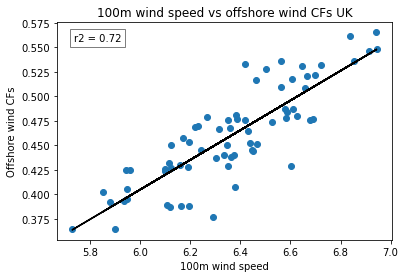

In [31]:
# plot a scttaer between 100m wind speed and ofs_cfs
plt.scatter(df_full_daily_ONDJFM["100m_wind_speed"], df_full_daily_ONDJFM["ofs_cfs"])

plt.xlabel("100m wind speed")
plt.ylabel("Offshore wind CFs")

# include a line of best fit
m, b = np.polyfit(
    df_full_daily_ONDJFM["100m_wind_speed"], df_full_daily_ONDJFM["ofs_cfs"], 1
)

plt.plot(df_full_daily_ONDJFM["100m_wind_speed"], m * df_full_daily_ONDJFM["100m_wind_speed"] + b, color="k")

# calculate the r2 value
r2 = np.corrcoef(df_full_daily_ONDJFM["100m_wind_speed"], df_full_daily_ONDJFM["ofs_cfs"])[0, 1] ** 2

# text in the top left with r2
plt.text(
    0.05,
    0.95,
    f"r2 = {r2:.2f}",
    horizontalalignment="left",
    verticalalignment="top",
    transform=plt.gca().transAxes,
    bbox=dict(facecolor="white", alpha=0.5),
)

# set the title
plt.title("100m wind speed vs offshore wind CFs UK")

plt.show()

In [22]:
def plot_scatter_with_fit(df, x_col, y_col, title, xlabel, ylabel):
    # plot a scatter between x_col and y_col
    plt.scatter(df[x_col], df[y_col])

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # include a line of best fit
    m, b = np.polyfit(df[x_col], df[y_col], 1)

    plt.plot(df[x_col], m * df[x_col] + b, color="k")

    # calculate the r2 value
    r2 = np.corrcoef(df[x_col], df[y_col])[0, 1] ** 2

    # text in the top left with r2
    plt.text(
        0.05,
        0.95,
        f"r2 = {r2:.2f}",
        horizontalalignment="left",
        verticalalignment="top",
        transform=plt.gca().transAxes,
        bbox=dict(facecolor="white", alpha=0.5),
    )

    # set the title
    plt.title(title)

    plt.show()

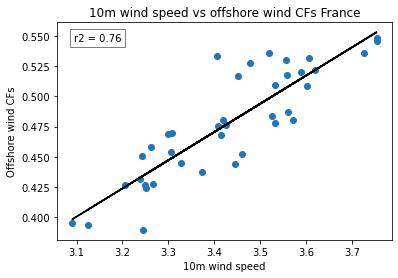

In [23]:
# plot scatter with fit for france
plot_scatter_with_fit(
    df=df_full_daily_fr_ONDJFM,
    x_col="10m_wind_speed",
    y_col="ofs_cfs",
    title="10m wind speed vs offshore wind CFs France",
    xlabel="10m wind speed",
    ylabel="Offshore wind CFs",
)

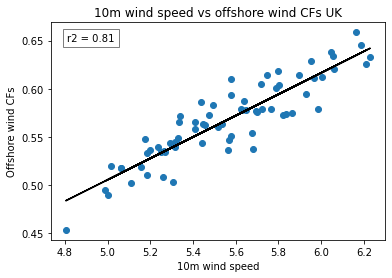

In [22]:
# plot_scatter_with_fit(
#     df=df_full_daily_ONDJFM,
#     x_col="10m_wind_speed",
#     y_col="ofs_cfs",
#     title="10m wind speed vs offshore wind CFs UK",
#     xlabel="10m wind speed",
#     ylabel="Offshore wind CFs",
# )

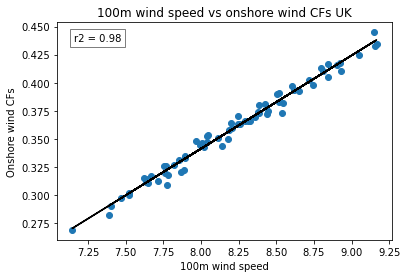

In [23]:
# # 100m and onshore wind speed
# plot_scatter_with_fit(
#     df=df_full_daily_ONDJFM,
#     x_col="100m_wind_speed",
#     y_col="ons_cfs",
#     title="100m wind speed vs onshore wind CFs UK",
#     xlabel="100m wind speed",
#     ylabel="Onshore wind CFs",
# )

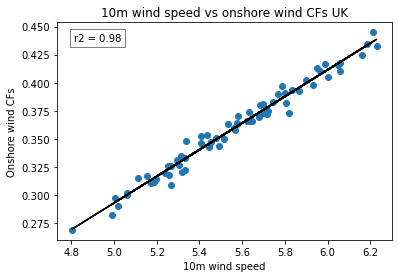

In [24]:
# # 10m and onshore wind speed
# plot_scatter_with_fit(
#     df=df_full_daily_ONDJFM,
#     x_col="10m_wind_speed",
#     y_col="ons_cfs",
#     title="10m wind speed vs onshore wind CFs UK",
#     xlabel="10m wind speed",
#     ylabel="Onshore wind CFs",
# )

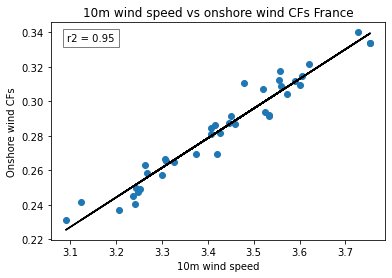

In [25]:
# 10m wind speed and onshore cfs france
plot_scatter_with_fit(
    df=df_full_daily_fr_ONDJFM,
    x_col="10m_wind_speed",
    y_col="ons_cfs",
    title="10m wind speed vs onshore wind CFs France",
    xlabel="10m wind speed",
    ylabel="Onshore wind CFs",
)

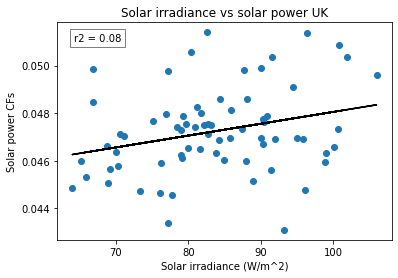

In [25]:
# # solar irradiance and solar power cfs
# plot_scatter_with_fit(
#     df=df_full_daily_ONDJFM,
#     x_col="solar_irradiance",
#     y_col="solar_power",
#     title="Solar irradiance vs solar power UK",
#     xlabel="Solar irradiance (W/m^2)",
#     ylabel="Solar power CFs",
# )

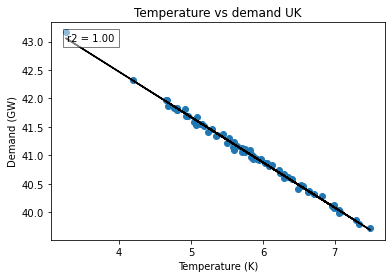

In [26]:
# # temperature and demand
# plot_scatter_with_fit(
#     df=df_full_daily_ONDJFM,
#     x_col="t2m_no_detrend",
#     y_col="United_Kingdom_demand",
#     title="Temperature vs demand UK",
#     xlabel="Temperature (K)",
#     ylabel="Demand (GW)",
# )

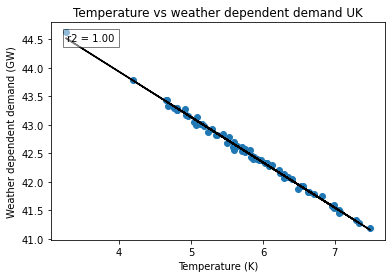

In [27]:
# # temperature and weather dependent demand
# plot_scatter_with_fit(
#     df=df_full_daily_ONDJFM,
#     x_col="t2m_no_detrend",
#     y_col="United_Kingdom_wd_demand",
#     title="Temperature vs weather dependent demand UK",
#     xlabel="Temperature (K)",
#     ylabel="Weather dependent demand (GW)",
# )

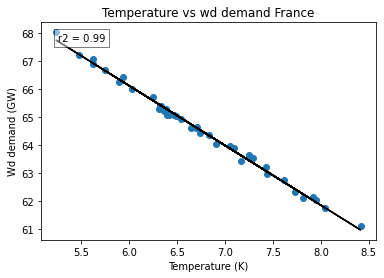

In [26]:
# temperature vs demand france
plot_scatter_with_fit(
    df=df_full_daily_fr_ONDJFM,
    x_col="t2m_no_detrend",
    y_col="France",
    title="Temperature vs wd demand France",
    xlabel="Temperature (K)",
    ylabel="Wd demand (GW)",
)

In [27]:
# Make some assumptions about the power system
# wind power capacity factors - includes both onshore and offshore?
# also I guess power system is 2021 ish set up?
# although won't have changed significantly since then
# Not sure how accurate these are leached from:
# https://windeurope.org/intelligence-platform/product/wind-energy-in-europe-2023-statistics-and-the-outlook-for-2024-2030/
installed_ofs_2023 = 14.756  # GW
installed_ons_2023 = 14.866  # GW

# set up these but for France
installed_ofs_2023_fr = 0.842  # GW
installed_ons_2023_fr = 21.935  # GW

In [35]:
# # calculate the wind power generation
# df_full_daily_ONDJFM["wind_gen"] = (
#     installed_ofs_2023 * df_full_daily_ONDJFM["ofs_cfs"]
#     + installed_ons_2023 * df_full_daily_ONDJFM["ons_cfs"]
# )

In [ ]:
df

In [29]:
# calculate the wind power generation for France
df_full_daily_fr_ONDJFM["wind_gen"] = (
    installed_ofs_2023_fr * df_full_daily_fr_ONDJFM["ofs_cfs"]
    + installed_ons_2023_fr * df_full_daily_fr_ONDJFM["ons_cfs"]
)

In [30]:
df_full_daily_fr_ONDJFM.head()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,France,wind_gen
time_in_hours_from_first_jan_1950,,,,,,,,,,
1979-12-31,0.075989,6.304454,3.373770,154.774170,0.437362,0.269183,6.470367,7.496370,65.085410,6.272780
1980-12-31,0.078974,6.659595,3.601234,119.972870,0.508677,0.309258,5.625437,6.625772,66.887542,7.211879
1981-12-31,0.076885,6.586526,3.525013,100.987968,0.484153,0.293557,6.419255,7.393959,65.081820,6.846824
1982-12-31,0.075277,6.577927,3.560119,128.208725,0.487228,0.308521,6.379771,7.328843,65.291905,7.177650
1983-12-31,0.081151,6.666558,3.589266,115.619293,0.520364,0.311750,5.939099,6.862504,66.441585,7.276382


In [30]:
# calculate the demand net wind
df_full_daily_ONDJFM["demand_net_wind"] = (
    df_full_daily_ONDJFM["United_Kingdom_demand"] - df_full_daily_ONDJFM["wind_gen"]
)

# calculate the weather dependent demand
df_full_daily_ONDJFM["wd_demand_net_wind"] = (
    df_full_daily_ONDJFM["United_Kingdom_wd_demand"] - df_full_daily_ONDJFM["wind_gen"]
)

In [31]:
# calculate the demand net wind for France
df_full_daily_fr_ONDJFM["wd_demand_net_wind"] = (
    df_full_daily_fr_ONDJFM["France"] - df_full_daily_fr_ONDJFM["wind_gen"]
)

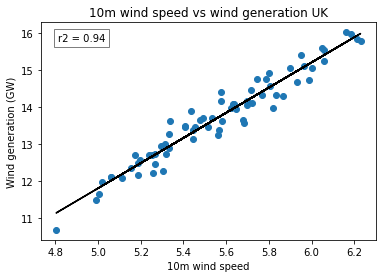

In [31]:
# plot 10m wind speed vs wind generation
plot_scatter_with_fit(
    df=df_full_daily_ONDJFM,
    x_col="10m_wind_speed",
    y_col="wind_gen",
    title="10m wind speed vs wind generation UK",
    xlabel="10m wind speed",
    ylabel="Wind generation (GW)",
)

In [ ]:
# 10m wind speed vs wind generation France
plot_scatter_with_fit(
    df=df_full_daily_fr_ONDJFM,
    x_col="10m_wind_speed",
    y_col="wind_gen",
    title="10m wind speed vs wind generation France",
    xlabel="10m wind speed",
    ylabel="Wind generation (GW)",
)

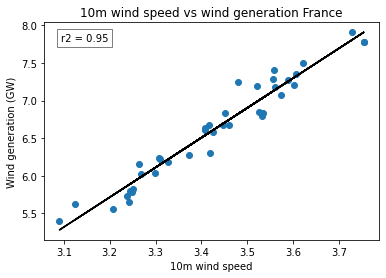

In [39]:
# plot the scatter of 10m wind speed and wind generation france
plot_scatter_with_fit(
    df=df_full_daily_fr_ONDJFM,
    x_col="10m_wind_speed",
    y_col="wind_gen",
    title="10m wind speed vs wind generation France",
    xlabel="10m wind speed",
    ylabel="Wind generation (GW)",
)

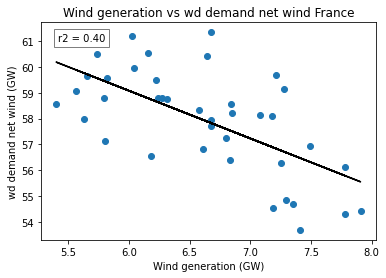

In [32]:
# wind generation vs demand net wind france
plot_scatter_with_fit(
    df=df_full_daily_fr_ONDJFM,
    x_col="wind_gen",
    y_col="wd_demand_net_wind",
    title="Wind generation vs wd demand net wind France",
    xlabel="Wind generation (GW)",
    ylabel="wd demand net wind (GW)",
)

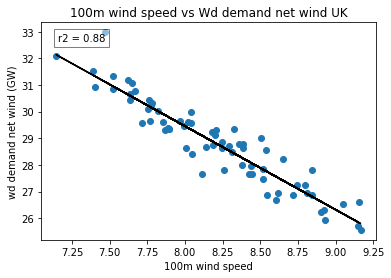

In [33]:
# scatter of 100m wind speed vs demand net wind
plot_scatter_with_fit(
    df=df_full_daily_ONDJFM,
    x_col="100m_wind_speed",
    y_col="wd_demand_net_wind",
    title="100m wind speed vs Wd demand net wind UK",
    xlabel="100m wind speed",
    ylabel="wd demand net wind (GW)",
)

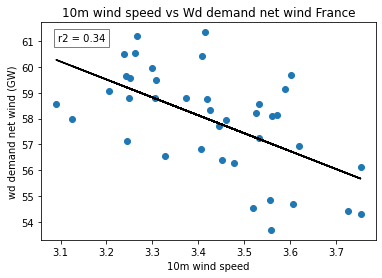

In [33]:
# 10m wind speed vs demand net wind france
plot_scatter_with_fit(
    df=df_full_daily_fr_ONDJFM,
    x_col="10m_wind_speed",
    y_col="wd_demand_net_wind",
    title="10m wind speed vs Wd demand net wind France",
    xlabel="10m wind speed",
    ylabel="wd demand net wind (GW)",
)

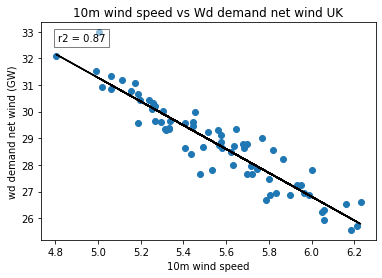

In [34]:
# 10m wind speed vs wd demand net wind
plot_scatter_with_fit(
    df=df_full_daily_ONDJFM,
    x_col="10m_wind_speed",
    y_col="wd_demand_net_wind",
    title="10m wind speed vs Wd demand net wind UK",
    xlabel="10m wind speed",
    ylabel="wd demand net wind (GW)",
)

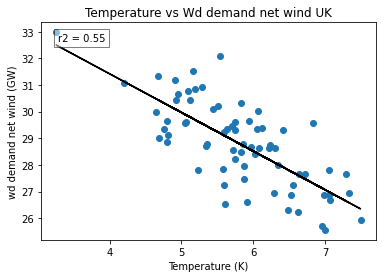

In [35]:
# temperature vs wd demand net wind
plot_scatter_with_fit(
    df=df_full_daily_ONDJFM,
    x_col="t2m_no_detrend",
    y_col="wd_demand_net_wind",
    title="Temperature vs Wd demand net wind UK",
    xlabel="Temperature (K)",
    ylabel="wd demand net wind (GW)",
)

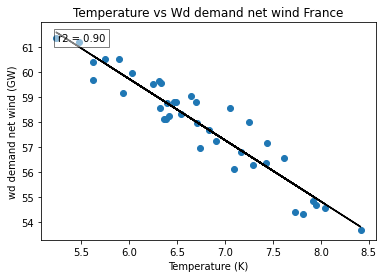

In [34]:
# temperature vs wd demand net wind france
plot_scatter_with_fit(
    df=df_full_daily_fr_ONDJFM,
    x_col="t2m_no_detrend",
    y_col="wd_demand_net_wind",
    title="Temperature vs Wd demand net wind France",
    xlabel="Temperature (K)",
    ylabel="wd demand net wind (GW)",
)

In [35]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def plot_3d_scatter(df, x_col, y_col, z_col, title, xlabel, ylabel, zlabel):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(df[x_col], df[y_col], df[z_col])

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_title(title)

    # Fit a multiple linear regression model
    X = df[[x_col, y_col]]
    y = df[z_col]
    model = LinearRegression().fit(X, y)

    # Calculate the R-squared value
    r2 = model.score(X, y)

    # Print the R-squared value
    print(f'R-squared: {r2:.2f}')

    # Plot the regression plane
    x_range = np.linspace(X[x_col].min(), X[x_col].max(), num=10)
    y_range = np.linspace(X[y_col].min(), X[y_col].max(), num=10)
    x_range, y_range = np.meshgrid(x_range, y_range)
    z_range = model.predict(np.array([x_range.flatten(), y_range.flatten()]).T).reshape(x_range.shape)
    ax.plot_surface(x_range, y_range, z_range, alpha=0.5)

    plt.show()

R-squared: 1.00


/apps/jasmin/jaspy/miniconda_envs/jaspy3.10/m3-4.9.2/envs/jaspy3.10-m3-4.9.2-r20220721/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


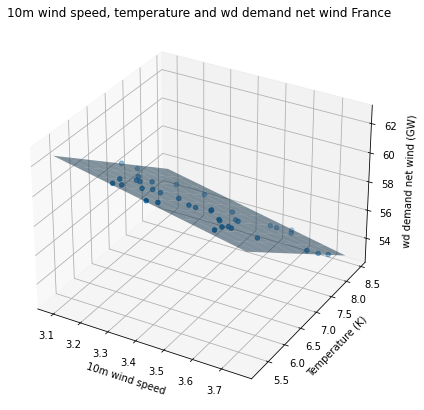

In [36]:
# 3d scatter of 10m wind speed, temperature and wd demand net wind for France
plot_3d_scatter(
    df=df_full_daily_fr_ONDJFM,
    x_col="10m_wind_speed",
    y_col="t2m_no_detrend",
    z_col="wd_demand_net_wind",
    title="10m wind speed, temperature and wd demand net wind France",
    xlabel="10m wind speed",
    ylabel="Temperature (K)",
    zlabel="wd demand net wind (GW)",
)

In [38]:
# print the head of the france dataframe
df_full_daily_fr_ONDJFM.tail()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,France,wind_gen,wd_demand_net_wind
time_in_hours_from_first_jan_1950,,,,,,,,,,,
2013-12-31,0.080024,6.722996,3.605718,153.233490,0.531642,0.314620,7.953366,8.107297,62.034021,7.348834,54.685187
2014-12-31,0.078027,6.244299,3.327229,133.994888,0.445081,0.264766,7.613498,7.741798,62.733621,6.182395,56.551226
2015-12-31,0.079074,6.563150,3.520391,110.865974,0.536007,0.307205,8.038466,8.141099,61.738416,7.189848,54.548568
2016-12-31,0.082256,5.946630,3.090433,138.610474,0.395122,0.230996,7.051356,7.128323,63.977065,5.399585,58.577480
2017-12-31,0.077737,6.581744,3.532207,141.975357,0.478311,0.291724,6.907159,6.958493,64.046033,6.801704,57.244329


R-squared: 0.97


/apps/jasmin/jaspy/miniconda_envs/jaspy3.10/m3-4.9.2/envs/jaspy3.10-m3-4.9.2-r20220721/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


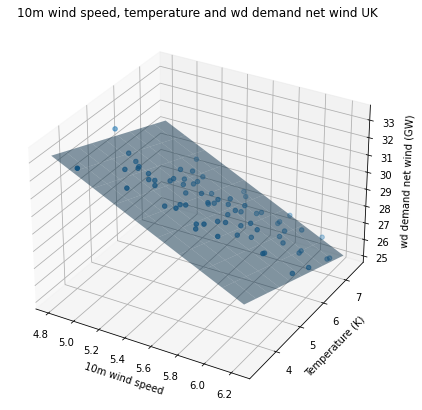

In [37]:
# 3d scatter of 100m wind speed, temperature and wd demand net wind
plot_3d_scatter(
    df=df_full_daily_ONDJFM,
    x_col="10m_wind_speed",
    y_col="t2m_no_detrend",
    z_col="wd_demand_net_wind",
    title="10m wind speed, temperature and wd demand net wind UK",
    xlabel="10m wind speed",
    ylabel="Temperature (K)",
    zlabel="wd demand net wind (GW)",
)

Now we want to test the strength of this MLR fit by providing the model with 10m wind speeds and 2m temperatures over the UK for a given season and getting it to predict the weather-dependent demand net wind.

We can then compare the results of this to our demand net wind variable and see how close they are.

In [38]:
# Fit a multiple linear regression model
# Fit a multiple linear regression model
X = df_full_daily_ONDJFM[["10m_wind_speed", "t2m_no_detrend"]]
y = df_full_daily_ONDJFM["wd_demand_net_wind"]
model = LinearRegression().fit(X, y)

# Calculate the R-squared value
r2 = model.score(X, y)

# Print the R-squared value
print(f'R-squared: {r2:.2f}')

# Predict the z values (i.e., wd_demand_net_wind) for the corresponding x and y values in each row
z_predicted = model.predict(X)

# Print the shape of the z_predicted
print(np.shape(z_predicted))

R-squared: 0.97
(70,)


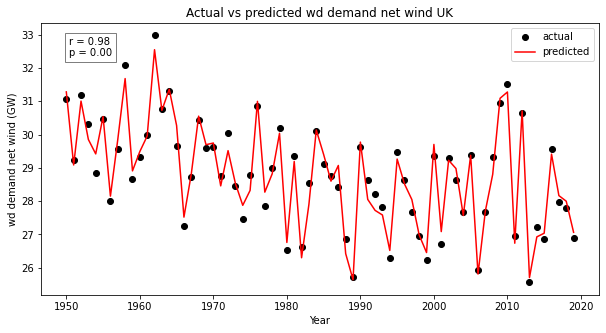

In [39]:
from scipy.stats import pearsonr

# set up a figure
fig = plt.figure(figsize=(10, 5))

# plot the actual wd demand net wind values
plt.scatter(df_full_daily_ONDJFM.index, df_full_daily_ONDJFM["wd_demand_net_wind"], label="actual", color="k")

# plot the predicted wd demand net wind values
plt.plot(df_full_daily_ONDJFM.index, z_predicted, label="predicted", color="r")

# set the title
plt.title("Actual vs predicted wd demand net wind UK")

# calculate the correlation between the actual and predicted values
r, p = pearsonr(df_full_daily_ONDJFM["wd_demand_net_wind"], z_predicted)

# text in the top left with r2
plt.text(
    0.05,
    0.95,
    f"r = {r:.2f}\np = {p:.2f}",
    horizontalalignment="left",
    verticalalignment="top",
    transform=plt.gca().transAxes,
    bbox=dict(facecolor="white", alpha=0.5),
)

# set the x label
plt.xlabel("Year")

# set the y label
plt.ylabel("wd demand net wind (GW)")

# show the legend
plt.legend()

Now import the temperature and wind speed data from DePreSys. It fails the fidelity tests for this test period (1960-1965) but that's kind of expected as we only have 5 observations and 50 model combinations.

We assume, therefore, that it has passed the fidelity tests, and now we are trying to translate the wind speeds and temperatures into demand net wind via our observed relationship.

In [40]:
# Set up the path to the data
csv_dir = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs"
sfcwind_fname = "HadGEM3-GC31-MM_sfcWind_United Kingdom_ONDJFM_1960_1962_dcppA-hindcast_Amon.csv"
t2m_fname = "HadGEM3-GC31-MM_tas_United Kingdom_ONDJFM_1960_1962_dcppA-hindcast_Amon.csv"

# Load the data
df_sfcwind = pd.read_csv(os.path.join(csv_dir, sfcwind_fname))

# Load the data
df_t2m = pd.read_csv(os.path.join(csv_dir, t2m_fname))

In [41]:
df_sfcwind.tail()

,init_year,member,lead,data
3745,1962,9,121,4.385972
3746,1962,9,122,5.015366
3747,1962,9,123,4.278336
3748,1962,9,124,4.757526
3749,1962,9,125,5.062733


In [42]:
df_t2m.tail()

,init_year,member,lead,data
3745,1962,9,121,278.192358
3746,1962,9,122,274.533515
3747,1962,9,123,271.200382
3748,1962,9,124,273.986996
3749,1962,9,125,274.724214


In [43]:
# rename the data column for df_sfcwind
df_sfcwind.rename(columns={"data": "sfcWind"}, inplace=True)

# rename the data column for df_t2m
df_t2m.rename(columns={"data": "tas"}, inplace=True)

In [44]:
# merge the dataframes
df = pd.merge(df_sfcwind, df_t2m, on=['init_year', 'member', 'lead'])

In [45]:
df.tail()

,init_year,member,lead,sfcWind,tas
3745,1962,9,121,4.385972,278.192358
3746,1962,9,122,5.015366,274.533515
3747,1962,9,123,4.278336,271.200382
3748,1962,9,124,4.757526,273.986996
3749,1962,9,125,5.062733,274.724214


In [46]:
# convert tas from K to C
df["tas"] = df["tas"] - 273.15

In [47]:
# create a new cf to calculate the means over the ONDJFM
df_new = pd.DataFrame()

# loop over the unique init years and members in df
for init_year in df['init_year'].unique():
    for member in df['member'].unique():
        # extract the model data
        model_data = df[(df['init_year'] == init_year) & (df['member'] == member)]

        # subset to lead values [12, 13, 14, 15, 16, 17] and take the mean
        # first complete ONDJFM season
        model_data = model_data[model_data['lead'].isin([12, 13, 14, 15, 16, 17])]

        mean_tas = model_data['tas'].mean()
        mean_sfcWind = model_data['sfcWind'].mean()

        # create a dataframe this
        model_data_this = pd.DataFrame(
            {
                'init_year': [init_year],
                'member': [member],
                'tas': [mean_tas],
                'sfcWind': [mean_sfcWind]
            }
        )

        df_new = pd.concat([df_new, model_data_this])


In [48]:
df_new.tail()

,init_year,member,tas,sfcWind
0,1962,5,5.210742,4.761705
0,1962,6,4.334656,4.850508
0,1962,7,5.784488,5.384064
0,1962,8,4.246524,5.375189
0,1962,9,4.572186,5.153319


Now load in the processed observations.

In [49]:
ERA5_tas_fname = "ERA5_obs_tas_United Kingdom_ONDJFM_1960_1962.csv"
ERA5_sfcWind_fname = "ERA5_obs_sfcWind_United Kingdom_ONDJFM_1960_1962.csv"

# Load the data
df_ERA5_tas = pd.read_csv(os.path.join(csv_dir, ERA5_tas_fname))
df_ERA5_sfcWind = pd.read_csv(os.path.join(csv_dir, ERA5_sfcWind_fname))

In [50]:
df_ERA5_tas

,time,obs
0,1960-10-01,282.668868
1,1960-11-01,279.559365
2,1960-12-01,276.477476
3,1961-01-01,275.904981
4,1961-02-01,279.151625
5,1961-03-01,280.353685
6,1961-04-01,281.654381
7,1961-05-01,283.033928
8,1961-06-01,286.179810
9,1961-07-01,287.023008


In [51]:
# reset the name of the obs column
df_ERA5_tas.rename(columns={"obs": "tas"}, inplace=True)
df_ERA5_sfcWind.rename(columns={"obs": "sfcWind"}, inplace=True)

In [52]:
# merge the dataframes
df_ERA5 = pd.merge(df_ERA5_tas, df_ERA5_sfcWind, on=['time'])

In [53]:
df_ERA5.head()

,time,tas,sfcWind
0,1960-10-01,282.668868,4.131944
1,1960-11-01,279.559365,4.934281
2,1960-12-01,276.477476,4.428460
3,1961-01-01,275.904981,4.940405
4,1961-02-01,279.151625,5.247938


In [54]:
# Make sure time is datetime
df_ERA5['time'] = pd.to_datetime(df_ERA5['time'])

# set the index to time
df_ERA5.set_index('time', inplace=True)

In [55]:
# subset to months (10, 11, 12, 1, 2, 3)
df_ERA5_ONDJFM = df_ERA5[(df_ERA5.index.month >= 10) | (df_ERA5.index.month <= 3)]

In [56]:
df_ERA5_ONDJFM.head()

,tas,sfcWind
time,,
1960-10-01,282.668868,4.131944
1960-11-01,279.559365,4.934281
1960-12-01,276.477476,4.428460
1961-01-01,275.904981,4.940405
1961-02-01,279.151625,5.247938


In [57]:
# shift back by 3 months and resample to yearly means
df_ERA5_ONDJFM = df_ERA5_ONDJFM.shift(-3, freq='M').resample('Y').mean()

/tmp/ipykernel_22855/1358686657.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_ERA5_ONDJFM = df_ERA5_ONDJFM.shift(-3, freq='M').resample('Y').mean()
/tmp/ipykernel_22855/1358686657.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_ERA5_ONDJFM = df_ERA5_ONDJFM.shift(-3, freq='M').resample('Y').mean()


In [58]:
df_ERA5_ONDJFM.head()

,tas,sfcWind
time,,
1960-12-31,279.019333,4.769488
1961-12-31,277.546575,4.943203
1962-12-31,275.847431,4.461803


In [59]:
df_new.head()

,init_year,member,tas,sfcWind
0,1960,10,4.687112,4.600986
0,1960,1,5.311010,4.820743
0,1960,2,3.118230,4.761391
0,1960,3,5.348982,4.939705
0,1960,4,4.684333,4.969560


In [60]:
# Convert ERA5 tas from K to C
df_ERA5_ONDJFM['tas'] = df_ERA5_ONDJFM['tas'] - 273.15

In [61]:
# calculate the mean bias for wind speed and temperature
sfcWind_bias = df_new['sfcWind'].mean() - df_ERA5_ONDJFM['sfcWind'].mean()

tas_bias = df_new['tas'].mean() - df_ERA5_ONDJFM['tas'].mean()

# print the biases
print(f"Mean bias sfcWind: {sfcWind_bias:.2f}")

print(f"Mean bias tas: {tas_bias:.2f}")

Mean bias sfcWind: 0.43
Mean bias tas: 0.33


Those look more sensible

Now we want to fit the model to the correct ERA5 tas and sfcWind data. Which has been regridded to the same grid as DePreSys and then masked for the UK at the same resolution.

In [62]:
df_full_daily_ONDJFM_subset.tail()

NameError: name 'df_full_daily_ONDJFM_subset' is not defined

In [63]:
# subset df_full_daily_ONDJFM to the same years as df_new
df_full_daily_ONDJFM_subset = df_full_daily_ONDJFM.loc[df_new['init_year'].unique()]

In [64]:
# create a new dataframe with the same index as df_full_daily_ONDJFM_subset
# but with sfcWind and tas from df_ERA5_ONDJFM
# and wd_demand_net_wind from df_full_daily_ONDJFM_subset
df_new_full = pd.DataFrame(index=df_full_daily_ONDJFM_subset.index)

# add the columns
df_new_full['sfcWind'] = df_ERA5_ONDJFM['sfcWind'].values
df_new_full['tas'] = df_ERA5_ONDJFM['tas'].values
df_new_full['wd_demand_net_wind'] = df_full_daily_ONDJFM_subset['wd_demand_net_wind'].values

In [65]:
df_new_full.head()

,sfcWind,tas,wd_demand_net_wind
1960,4.769488,5.869333,29.328790
1961,4.943203,4.396575,29.978915
1962,4.461803,2.697431,32.978647


In [66]:
# add the temperature and wind speed data from hannah stuff
df_new_full['tas_ch'] = df_full_daily_ONDJFM_subset['t2m_no_detrend'].values
df_new_full['sfcWind_ch'] = df_full_daily_ONDJFM_subset['10m_wind_speed'].values

In [67]:
df_new_full.head()

,sfcWind,tas,wd_demand_net_wind,tas_ch,sfcWind_ch
1960,4.769488,5.869333,29.328790,6.046000,5.314873
1961,4.943203,4.396575,29.978915,4.647103,5.455883
1962,4.461803,2.697431,32.978647,3.256981,5.002560


In [68]:
# add wind generation and wd demand to the df_new_full
df_new_full['wind_gen'] = df_full_daily_ONDJFM_subset['wind_gen'].values
df_new_full['United_Kingdom_wd_demand'] = df_full_daily_ONDJFM_subset['United_Kingdom_wd_demand'].values

In [69]:
df_new_full.head()

,sfcWind,tas,wd_demand_net_wind,tas_ch,sfcWind_ch,wind_gen,United_Kingdom_wd_demand
1960,4.769488,5.869333,29.328790,6.046000,5.314873,13.009050,42.337840
1961,4.943203,4.396575,29.978915,4.647103,5.455883,13.457975,43.436890
1962,4.461803,2.697431,32.978647,3.256981,5.002560,11.647347,44.625994


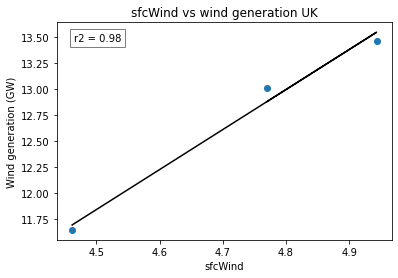

In [70]:
# plot the scatter between the sfcWind and the wind generation
plot_scatter_with_fit(
    df=df_new_full,
    x_col="sfcWind",
    y_col="wind_gen",
    title="sfcWind vs wind generation UK",
    xlabel="sfcWind",
    ylabel="Wind generation (GW)",
)

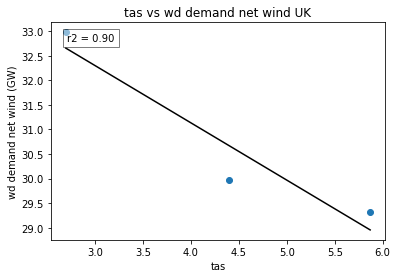

In [71]:
# plot the scatter between the temperature and the UK wd demand
plot_scatter_with_fit(
    df=df_new_full,
    x_col="tas",
    y_col="wd_demand_net_wind",
    title="tas vs wd demand net wind UK",
    xlabel="tas",
    ylabel="wd demand net wind (GW)",
)

Very weak (no?) relationships between the monthly means and the variables. Quite surprising really?

Is this masking to the correct location?

R-squared: 1.00


/apps/jasmin/jaspy/miniconda_envs/jaspy3.10/m3-4.9.2/envs/jaspy3.10-m3-4.9.2-r20220721/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


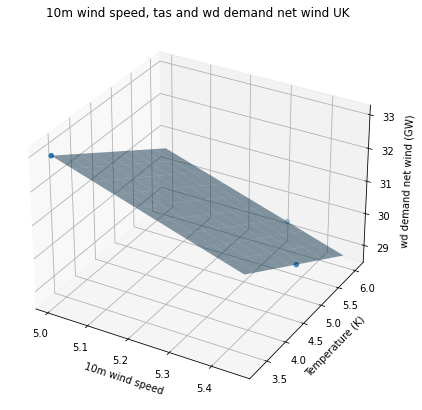

In [72]:
# fit a multiple linear regression model
plot_3d_scatter(
    df=df_new_full,
    x_col="sfcWind_ch",
    y_col="tas_ch",
    z_col="wd_demand_net_wind",
    title="10m wind speed, tas and wd demand net wind UK",
    xlabel="10m wind speed",
    ylabel="Temperature (K)",
    zlabel="wd demand net wind (GW)",
)

R-squared: 1.00


/apps/jasmin/jaspy/miniconda_envs/jaspy3.10/m3-4.9.2/envs/jaspy3.10-m3-4.9.2-r20220721/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


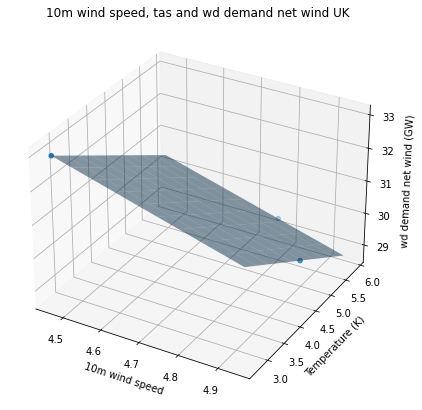

In [73]:
# fit a multiple linear regression model
plot_3d_scatter(
    df=df_new_full,
    x_col="sfcWind",
    y_col="tas",
    z_col="wd_demand_net_wind",
    title="10m wind speed, tas and wd demand net wind UK",
    xlabel="10m wind speed",
    ylabel="Temperature (K)",
    zlabel="wd demand net wind (GW)",
)

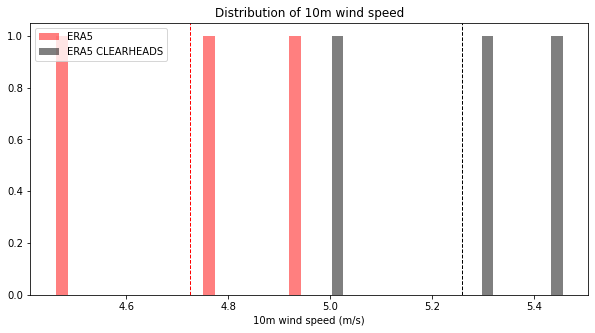

In [74]:
# plot the distibution of the sfcwind and sfcwind_ch
# set up the figure
plt.figure(figsize=(10, 5))

plt.hist(df_new_full['sfcWind'], bins=20, alpha=0.5, label='ERA5', color='r')
plt.hist(df_new_full['sfcWind_ch'], bins=20, alpha=0.5, label='ERA5 CLEARHEADS', color='k')

plt.xlabel('10m wind speed (m/s)')

plt.legend()

# include the mean as a vertical line
plt.axvline(df_new_full['sfcWind'].mean(), color='r', linestyle='dashed', linewidth=1)

plt.axvline(df_new_full['sfcWind_ch'].mean(), color='k', linestyle='dashed', linewidth=1)

# set a title
plt.title('Distribution of 10m wind speed')

plt.show()

ERA5 regrid own method 10m wind speeds much higher than CLEARHEADS. Appears to have more spread as well.

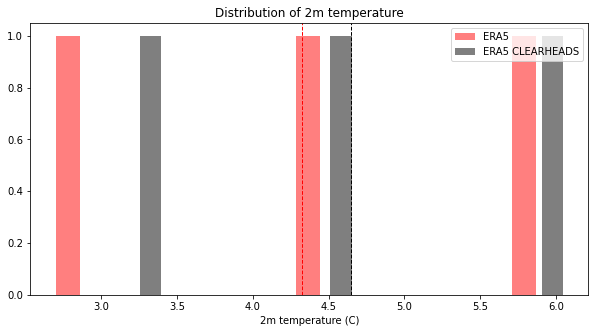

In [75]:
# plot the distibution of the tas and tas_ch
# set up the figure
plt.figure(figsize=(10, 5))

plt.hist(df_new_full['tas'], bins=20, alpha=0.5, label='ERA5', color='r')
plt.hist(df_new_full['tas_ch'], bins=20, alpha=0.5, label='ERA5 CLEARHEADS', color='k')

plt.xlabel('2m temperature (C)')

plt.legend()

# include the mean as a vertical line
plt.axvline(df_new_full['tas'].mean(), color='r', linestyle='dashed', linewidth=1)

plt.axvline(df_new_full['tas_ch'].mean(), color='k', linestyle='dashed', linewidth=1)

# set a title
plt.title('Distribution of 2m temperature')

plt.show()


Text(0.5, 1.0, 'Time series of 10m wind speed: ERA5 vs ERA5 CLEARHEADS')

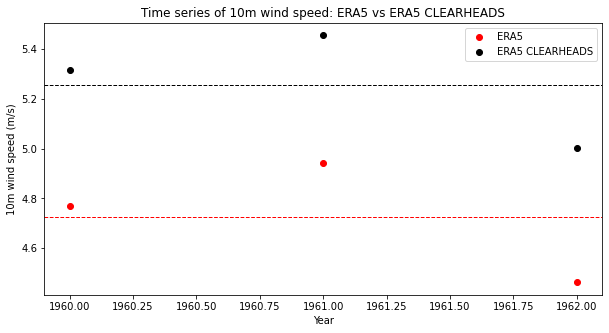

In [76]:
# plot the time series of the wind speed
plt.figure(figsize=(10, 5))

plt.scatter(df_new_full.index, df_new_full['sfcWind'], label='ERA5', color='r')
plt.scatter(df_new_full.index, df_new_full['sfcWind_ch'], label='ERA5 CLEARHEADS', color='k')

plt.xlabel('Year')
plt.ylabel('10m wind speed (m/s)')

# include the mean as a horizontal line
plt.axhline(df_new_full['sfcWind'].mean(), color='r', linestyle='dashed', linewidth=1)
plt.axhline(df_new_full['sfcWind_ch'].mean(), color='k', linestyle='dashed', linewidth=1)

plt.legend()

plt.title('Time series of 10m wind speed: ERA5 vs ERA5 CLEARHEADS')

Text(0.5, 1.0, 'Time series of 2m temperature: ERA5 vs ERA5 CLEARHEADS')

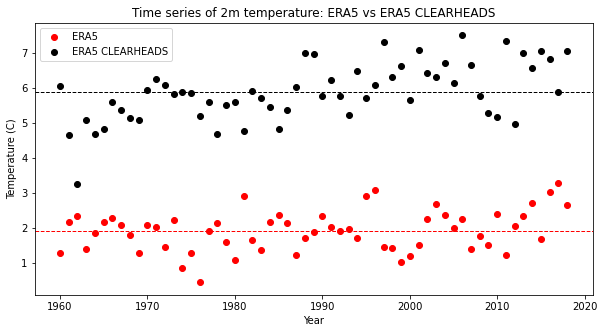

In [ ]:
# same but for temperature
plt.figure(figsize=(10, 5))

plt.scatter(df_new_full.index, df_new_full['tas'], label='ERA5', color='r')
plt.scatter(df_new_full.index, df_new_full['tas_ch'], label='ERA5 CLEARHEADS', color='k')

plt.xlabel('Year')
plt.ylabel('Temperature (C)')

# include the mean as a horizontal line
plt.axhline(df_new_full['tas'].mean(), color='r', linestyle='dashed', linewidth=1)
plt.axhline(df_new_full['tas_ch'].mean(), color='k', linestyle='dashed', linewidth=1)

plt.legend()

plt.title('Time series of 2m temperature: ERA5 vs ERA5 CLEARHEADS')

ERA5 regrid own method 2m temperature ~4K lower than CLEARHEADS. Spread looks similar-ish, maybe more spread for CLEARHEADS?

Relationship is now super weak, why?

In [56]:
# set up the predictors
X_model = df_new[["sfcWind", "tas"]]

# predict the wd demand net wind
df_new["wd_demand_net_wind_pred"] = model.predict(X_model)

/apps/jasmin/jaspy/miniconda_envs/jaspy3.10/m3-4.9.2/envs/jaspy3.10-m3-4.9.2-r20220721/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- sfcWind
- tas
Feature names seen at fit time, yet now missing:
- 10m_wind_speed
- t2m_no_detrend

  warnings.warn(message, FutureWarning)


In [58]:
df_new.tail()

,init_year,member,tas,sfcWind,wd_demand_net_wind_pred
0,1965,5,2.112552,10.577661,13.329649
0,1965,6,1.540891,10.461658,14.143121
0,1965,7,1.063251,10.056174,15.930461
0,1965,8,1.695330,10.802726,12.811498
0,1965,9,1.414509,10.719741,13.304441


In [59]:
# print the min and max of the predicted wd demand net wind
print(df_new["wd_demand_net_wind_pred"].min())
print(df_new["wd_demand_net_wind_pred"].max())

12.321390576936885
18.29980755598997


Seems far too low. Perhaps a result of the mean biases in the model. The observed wind speeds are biased low (i.e. ERA5 winds are too still) so demand net wind will be higher as a result. While the observed temperatures are biased high, which will mean reduced winter demand? Winds are likely more of a dominant influence in the model though. Will have to do this with the full data.